# TP : Sentiment analysis on IMDB movie reviews

DAGHMOURA Haithem and Jalal KHALDI

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.
4. Experiment with various way to reduce the vocabulary size and look at the distribution obtained.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [17]:
import os.path as op
import re
import numpy as np
import matplotlib.pyplot as plt

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [18]:
from glob import glob
# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.','aclImdb','train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.','aclImdb','train', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.

In [19]:
print(f"This data set contains {len(train_labels)} document, {len(train_texts_neg)} of class 0 and {len(train_texts_pos)} of class 1")

This data set contains 25000 document, 12500 of class 0 and 12500 of class 1


In [20]:
lenths = [len(train_texts[i]) for i in range (25000)]
print(f"each sample of this data contains on average {round(np.mean(lenths))} with std {np.round(np.sqrt(np.var(lenths)))} the max length is {np.max(lenths)} and min is : {np.min(lenths)}")

each sample of this data contains on average 1325 with std 1003.0 the max length is 13704 and min is : 52


In [21]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

The number k affects the number of instances on our data. The lower is k the more data we have and thus the more vocabulary we can get. This will increase our accuracy later on since we will be able to get more information from the data (more words and more instances of each class)

In [22]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2,random_state=0)

## I - Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document.

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$.

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document.

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [26]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
Bow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

### Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words).
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations.
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [27]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    tokens = text.split()
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

<div class='alert alert-block alert-info'>
            Code:</div>

In [29]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    vocabulary_set = set()
    texts_tokenized = []
    for text in texts :
      text_tokenized =  clean_and_tokenize(text)
      texts_tokenized.append(text_tokenized)
      vocabulary_set.update(text_tokenized)


    counts_shape = (len(texts),len(vocabulary_set))
    counts = np.zeros(counts_shape)

    vocabulary= {element: index for index, element in enumerate(vocabulary_set)}

    for text_tokens_index in range(len(texts_tokenized)) :
      text_tokens = texts_tokenized[text_tokens_index]

      for index in range(len(text_tokens)) :
          cur_word = text_tokens[index]
          counts[ text_tokens_index,vocabulary[cur_word]] +=1


    return vocabulary, counts

In [30]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'avenue': 0, 'the': 1, 'boulevard': 2, 'walked': 3, 'ran': 4, 'walk': 5, 'down': 6, 'city': 7}
[[0. 1. 1. 1. 0. 0. 2. 0.]
 [1. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 1. 1.]
 [1. 2. 0. 0. 0. 1. 1. 0.]]


Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how CountVectorizer does it:

In [31]:
val_corpus = ['I walked up the street']
Bow = vectorizer.transform(val_corpus)
Bow.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1]])

Modify the ```count_words``` function to be able to deal with new documents when given a previously obtained vocabulary !

<div class='alert alert-block alert-info'>
            Code:</div>

In [32]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    voc : dict
        A dictionary that points to an index in counts for each word - output by a previous use of the function
        If not None, use this one
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    if voc == None:
      vocabulary_set = set()
      texts_tokenized = []
      for text in texts :
        text_tokenized =  clean_and_tokenize(text)
        texts_tokenized.append(text_tokenized)
        vocabulary_set.update(text_tokenized)


      counts_shape = (len(texts),len(vocabulary_set))
      counts = np.zeros(counts_shape)

      vocabulary= {element: index for index, element in enumerate(vocabulary_set)}

      for text_tokens_index in range(len(texts_tokenized)) :
        text_tokens = texts_tokenized[text_tokens_index]

        for index in range(len(text_tokens)) :
            cur_word = text_tokens[index]
            counts[ text_tokens_index,vocabulary[cur_word]] +=1
    else:
      texts_tokenized = []
      for text in texts :
        text_tokenized =  clean_and_tokenize(text)
        texts_tokenized.append(text_tokenized)
      counts_shape = (len(texts),len(voc))
      counts = np.zeros(counts_shape)
      vocabulary= voc

      for text_tokens_index in range(len(texts_tokenized)) :
        text_tokens = texts_tokenized[text_tokens_index]

        for index in range(len(text_tokens)) :
            cur_word = text_tokens[index]
            if cur_word in vocabulary:
              counts[ text_tokens_index,vocabulary[cur_word]] +=1


    return vocabulary, counts

<div class='alert alert-block alert-warning'>
            Questions:</div>                       

Careful: check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What ```CountVectorizer``` argument allows to avoid the issue ?

<div class='alert alert-block alert-info'>
            Code:</div>

**Answer**

we noitice that the size of document vector representation is equal to 29803.
The arguement that can help mitigate memory issues when using CountVectorizer is max_df (maximum document frequency). This parameter specifies a threshold such that words that occur in more than a certain percentage of documents will be ignored. Ignoring very common words can reduce memory usage and can sometimes improve the quality of the features by focusing on more informative terms. an other possible argument is the max_features argument that specifies the maximum number of words that we will consider. Last but not least, the representation of the matrix itself is compressed by using CountVectorizer. In fact, since the count matrix contains a lot of zeros it is considered as a parse matrix and thus a more dedicated structure allows for optimizing memory use.


In [33]:
voc, train_bow = count_words(train_texts_splt)
print(train_bow.shape)

(2000, 29583)


In [34]:
_, val_bow = count_words(val_texts, voc)
print(val_bow.shape)

(500, 29583)


In [35]:
# Do the same with a CountVectorizer: create and fit the vectorizer to the training data
vectorizer = CountVectorizer()

train_bow = vectorizer.fit_transform(train_texts_splt)

print(train_bow.shape)


(2000, 25499)


In [36]:
# Transform the validation data
val_bow = vectorizer.transform(val_texts)
print(val_bow.shape)

(500, 25499)


## II- Naive Bayesian

### Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** :

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$

### General view

#### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

#### Test: Calculating scores

To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities :

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

#### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the *Laplace smoothing*:

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications.

### Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

#### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{|\text{documents in class }c|}{|\text{all documents}|}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

### Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix.
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

#### Procedure:

- For each of the classes $c$,
    - $Score(c) = \log P(c)$
    - For each word $w$ in the document to be tested:
        - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$

We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.
```python
def fit(self, X, y)
```
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above.

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [37]:
class NB(BaseEstimator, ClassifierMixin):
    # Les arguments de classe permettent l'héritage de classes de sklearn
    def __init__(self, alpha=1.0):
        # alpha is the smoothing parameter: it corresponds to line 10 of the training algorithm
        # By default, we use alpha = 1
        self.alpha = alpha

    def counts_words_per_class(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        :param X: X contains representations obtained as the output of count_words
        :param y: array that represents labels of documents
        :return: t such that T(w,c) (number of occurences of w for a documents labeled c)
        """
        n, d = X.shape
        classes = np.unique(y)
        t = np.zeros((d,classes.shape[0]))
        for c in range(classes.shape[0]) :
            for i_w in range(d) :
                t[i_w,c] = np.sum(X[y==c, i_w], axis =0)
        return t

    def conditional_dist(self, t: np.ndarray) -> np.ndarray:
        d, num_classes = t.shape
        distr_words_knc: np.ndarray = np.zeros((d,num_classes))
        for c in range(num_classes) :
            for i_w in range(d) :
                num_words_inc_smoothed = np.sum(t[:,c] + self.alpha)
                distr_words_knc[i_w, c] = (t[i_w,c] + self.alpha) / num_words_inc_smoothed
        return distr_words_knc

    def fit(self, X, y):
        n, d = X.shape
        t: np.ndarray = self.counts_words_per_class(X, y)
        classes = list(np.unique(y))
        self.distr_words_knc: np.ndarray = self.conditional_dist(t)
        self.p = np.array([X[y == c, :].shape[0] / n for c in classes])
        return self



    def predict(self, X):
        d, num_classes = self.distr_words_knc.shape
        n_rows = X.shape[0]
        def predict_rowi(Xi: np.ndarray) -> np.ndarray :
            scores = np.zeros(num_classes)
            for c in range(num_classes) :
                scores[c] += np.log(self.p[c])
                for i_w in range(d):

                    if Xi[i_w] > 0 :
                        scores[c] += Xi[i_w] * np.log(self.distr_words_knc[i_w,c])
            return np.argmax(scores)
        return np.array([predict_rowi(X[row_i,:]) for row_i in range(n_rows)])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

Here is an example of use for this classe and the results it give

In [38]:
voc, train_bow = count_words(train_texts_splt)
_, val_bow = count_words(val_texts, voc)

classifier = NB()
classifier.fit(train_bow,train_labels_splt)
classifier.score (val_bow,val_labels)

0.808

## III - Experimentation

Experiment on this model with your own representations. **Visualize** the results with the following tools, and **compare with the representations of ```CountVectorizer```/ naïve Bayes model of scikit-learn ```MultinomialNB```:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [40]:
from sklearn.naive_bayes import MultinomialNB

Score on validation set: 0.808
Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       250
           1       0.84      0.76      0.80       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



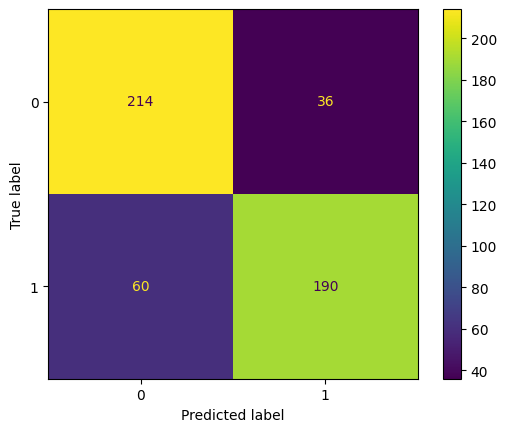

In [41]:
# compute the BOW and the vocabulary on the training set and used it to vectorize the valid set
voc, train_bow = count_words(train_texts_splt)
_, val_bow = count_words(val_texts, voc)

# Create the model
nb = NB()

# Fit the model
nb.fit(train_bow, train_labels_splt)

#Test on validation set
score = nb.score(val_bow, val_labels)
print('Score on validation set:', score)

#Predict on validation set
y_pred = nb.predict(val_bow)

#Confusion matrix
cm = confusion_matrix(val_labels, y_pred)
ConfusionMatrixDisplay(cm).plot()

#Classification report
report = classification_report(val_labels, y_pred)
print("Classification report: \n", report)


Score on validation set: 0.794
Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       250
           1       0.83      0.74      0.78       250

    accuracy                           0.79       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.80      0.79      0.79       500



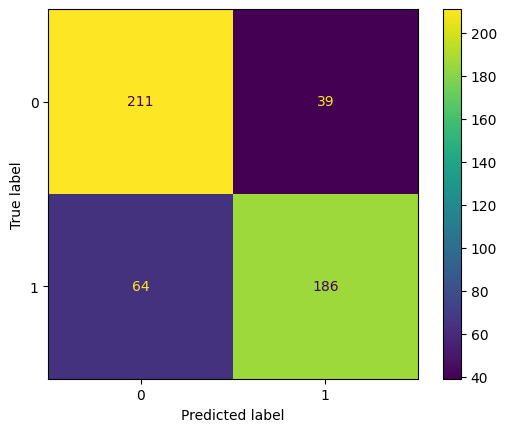

In [42]:
# Transform data using the countvecrorizer
vectorizer = CountVectorizer()
train_bow_to_comp = vectorizer.fit_transform(train_texts_splt)

# Transform the validation data
val_bow_to_comp = vectorizer.transform(val_texts)

# Create the model
nb_to_comp = MultinomialNB()
# Fit the model
nb_to_comp.fit(train_bow_to_comp, train_labels_splt)

#Test on validation set
score_to_comp = nb_to_comp.score(val_bow_to_comp, val_labels)
print('Score on validation set:', score_to_comp)

#Predict on validation set
y_pred_to_comp = nb_to_comp.predict(val_bow_to_comp)

#Confusion matrix
cm_to_comp = confusion_matrix(val_labels, y_pred_to_comp)
ConfusionMatrixDisplay(cm_to_comp).plot()

#Classification report
report_to_comp = classification_report(val_labels, y_pred_to_comp)
print("Classification report: \n", report_to_comp)

Upon comparing the results, it seems that the implementation of scikit-learn has slightly better accuracy

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Let us look at the *features* built by the ```vectorizer```. What seems to be the issue ?

In order to explain this differnce, two things comes to mind. First, the vocabulary that is obtained using the vectorizer has less elements than that obtained by count_words method. This is due to the fact that the vectorizer gets rid of the element that are present in alot of documents and have nearly no effect on the class. Second, The vectorizer takes into account numbers. In opposition, we got rid of them in our implementation.

In [43]:
print(vectorizer.get_feature_names_out()[:100])

['00' '000' '00001' '007' '0079' '0080' '0083' '02' '05' '07' '08' '10'
 '100' '1000' '100m' '101' '102' '103' '105' '10th' '10yr' '11' '110' '12'
 '120' '123' '125' '12s' '12th' '13' '130' '134' '13th' '14' '145' '147'
 '14ieme' '14th' '15' '150' '16' '161' '1692' '16th' '16ème' '17' '1700'
 '1794' '17th' '18' '180' '1814' '1824' '1840' '1850' '1864' '1880'
 '1880s' '1889' '1892' '1895' '1897' '18th' '19' '1902' '1907' '1910'
 '1911' '1912' '1918' '1920' '1920s' '1921' '1922' '1924' '1925' '1927'
 '1928' '1929' '1930' '1930s' '1931' '1932' '1933' '1934' '1935' '1936'
 '1937' '1938' '1939' '1940' '1940s' '1941' '1942' '1943' '1944' '1945'
 '1946' '1947' '1948']


In [44]:
feature_names= list(voc.keys())
feature_names[:100]


['whove',
 'discerned',
 'actresses',
 'monumentsstatuesfurnituredelicioushowever',
 'shouts',
 'expectedits',
 'pettiness',
 'crimes',
 'meteorites',
 'marcuss',
 'forth<',
 'conventional',
 'engrossed',
 'debt',
 'skinny',
 'unprecedented',
 'mouthpiece',
 'achieve<',
 'landons',
 '>enough',
 'amigos',
 'leonardo',
 'decades',
 'quotes',
 'sexiest',
 'snag',
 'refuse',
 'pumpkin',
 'structurally',
 'amrohi',
 'cap',
 'mornell',
 'child',
 'boringly',
 'lofty',
 'miike',
 'song',
 'pembleton',
 'snippets',
 'introspection',
 'soprano',
 'cal',
 'town',
 'whales',
 'prowls',
 'vehicles',
 '>violent',
 'glued',
 'coincides',
 'awfully',
 'complication',
 'amer',
 'nobleman',
 'prospects',
 'boost',
 'upper',
 'idiotically',
 'mannerisms',
 'karen',
 'charlatans',
 'kiddie',
 'rides',
 'inception',
 'reticent',
 'desent',
 'not<',
 'dullness',
 'colonial',
 'checkbook',
 'comediesbut',
 'literature',
 'peoplepusses',
 'unbeknownest',
 'supervise',
 'ropes',
 'genresee',
 'mindedness',
 '

### Improving representations

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account.

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course.
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity: **obtain classification results with them**.

Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with ! To accelerate experiments, use the ```Pipeline``` tool from scikit-learn.

<div class='alert alert-block alert-info'>
            Code:</div>

In [45]:
from sklearn.pipeline import Pipeline

In [46]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       250
           1       0.83      0.74      0.78       250

    accuracy                           0.79       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.80      0.79      0.79       500



In [47]:
pipeline_grid = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])
param_grid = {
    'vect__max_df': [0.5, 0.75,0.85, 1.0],
    'vect__min_df': [1, 2, 5],
    'vect__analyzer': ['word', 'char'],
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2),(3,3)],
    'vect__max_features' : [30000],
    'vect__stop_words' :  [None]
}

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:

grid_search = GridSearchCV(pipeline_grid, param_grid, scoring="f1", n_jobs=-1, cv=5) # We use cross validation

In [50]:
grid_search.fit(train_texts_splt, train_labels_splt)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__analyzer': ['word', 'char'],
                         'vect__max_df': [0.5, 0.75, 0.85, 1.0],
                         'vect__max_features': [30000],
                         'vect__min_df': [1, 2, 5],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)],
                         'vect__stop_words': [None]},
             scoring='f1')

In [51]:
grid_search.best_params_

{'vect__analyzer': 'word',
 'vect__max_df': 0.5,
 'vect__max_features': 30000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [52]:
best_params: dict[str, object] = {key[6:] : value for key, value in
                                    zip(grid_search.best_params_.keys(),
                                        grid_search.best_params_.values()
                                        )
                                  }
best_params

{'analyzer': 'word',
 'max_df': 0.5,
 'max_features': 30000,
 'min_df': 5,
 'ngram_range': (1, 2),
 'stop_words': None}

In [53]:
print("Best score: {:.4f}".format(grid_search.best_score_))

Best score: 0.8363


In [72]:

best_model_variance = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model_variance

0.014912457542580273

We can see the best params that produce the best metrics values (see above)
We have used the following strategy :    

-We have create a list of possible hyperparameters, mainly our focus was on the max_df and min_df params. To find the best model with this pool of parameters we have opted for the crossvalidation procdure. With 5 partitions in the training data set : 4 were used for the training of the current model and one for validating it. We used f1-score as a metric of evaluation of the test set (partition 1 over 5).

For each combination of hyperparemeters we get f1 score metric (mean over the five training and the variance of this metric). This method enables us to avoid overfitting and underfitting of model since for a given combination of hyperparemeters we have a high average of f1-score  the model isn't underfit and when we have a low variance we avoid overfitting.

**Conclusion**
We have found the optimal set of hyperparameters amoung the given pool. We have an average of f1-score = 0.8363 and a variance of 0.015 which means that our model is performant and is not overfitted. Furthermore, the model doesn't underfit the data because the average of metrics is high.

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       250
           1       0.83      0.83      0.83       250

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



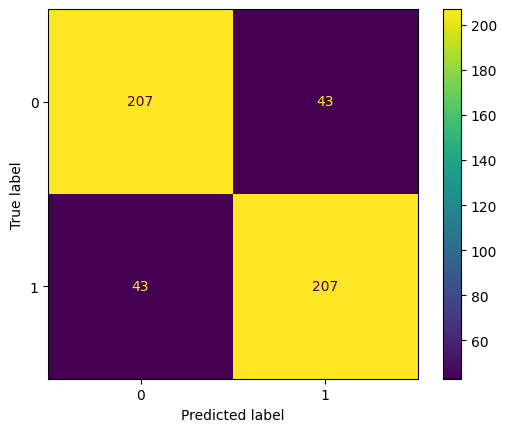

In [54]:
def get_results(y_true: np.ndarray, y_pred: np.ndarray) -> None :
    """
    :param y_true: true labels
    :param y_pred: labels predicted (for a specific model)
    print evaluation metrics for the model tied to y_pred
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(conf_matrix).plot()
    print(classification_report(y_true, y_pred))

pipeline_base = Pipeline([
    ('vect', CountVectorizer(**best_params)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
get_results(val_labels, val_pred)

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents.

Experiment with this new representations using the ```TfidfTransformer``` applied on top of ```CountVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       250
           1       0.85      0.82      0.83       250

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



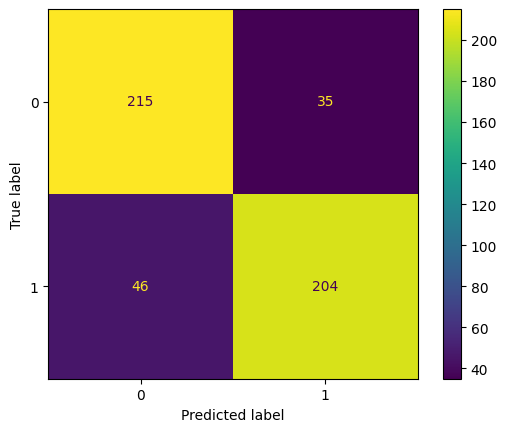

In [56]:
best_params = {'analyzer': 'word',
 'max_df': 0.5,
 'max_features': 30000,
 'min_df': 5,
 'ngram_range': (1, 2),
 'stop_words': None}
pipeline_base = Pipeline([
    ('vect', CountVectorizer(**best_params)),
    ('tfid', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
get_results(val_labels, val_pred)

## IV - More pre-processing: getting vocabularies

For more flexibility, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a **maximum number of words**, or a **minimum number of occurrences** to take the words into account. **We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary**.
<div class='alert alert-block alert-info'>
            Code:</div>

In [57]:
def vocabulary(corpus, count_threshold=0, voc_threshold=10000):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    words = set()

    tokenized_texts = []
    for sent in corpus:

            text = word_tokenize(sent.lower())
            words .update(text)
            tokenized_texts.append(text)

    counts_words = dict(zip(list(words), np.zeros(len(words), dtype=int)))

    # Count the words
    for text in tokenized_texts:
        for word in text:
            counts_words[word] += 1

    filtered_word_counts = {} # Filter according to count_threhshold
    for word in counts_words:
        count_aux = counts_words[word]
        if count_aux >= count_threshold:
            filtered_word_counts[word] = count_aux


    # Extract the words according to frequency
    sorted_words = sorted(filtered_word_counts.items(), key = lambda val:(-val[1], val[0]))

    # Remove the words above voc-threshold
    if voc_threshold == 0:
        filtered_words = dict(sorted_words)
    else:
        if len(sorted_words) < voc_threshold:
            filtered_words = dict(sorted_words)
        else:
            filtered_words = dict(sorted_words[:voc_threshold])


    # Add UNK
    words = filtered_words
    words['UNK'] = np.sum ([counts_words[i] for i in counts_words.keys()]) -np.sum ([filtered_words[i] for i in filtered_words.keys()])

    # Create vocabulary from "words"
    vocabulary = dict(zip(list(words), np.arange(len(filtered_words)+1, dtype=int)))

    return vocabulary, words

In [58]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
# (In this example, we don't count 'UNK' unknown words, but you can if you want to.
# How useful it may be depends on the data -> we will use the counts later with word2vec, keep that in mind)
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'i': 5, 'UNK': 10}
{'down': 0, 'the': 1, 'i': 2, 'avenue': 3, 'boulevard': 4, 'walk': 5, 'walked': 6, 'city': 7, 'ran': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'avenue': 2, 'boulevard': 2, 'walk': 2, 'walked': 2, 'city': 1, 'ran': 1, 'UNK': 0}


### Quick study of the data

We would like to get an idea of what's in these film reviews. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

<div class='alert alert-block alert-info'>
            Code:</div>

Here we see that we found the Zipf's distribution as expected

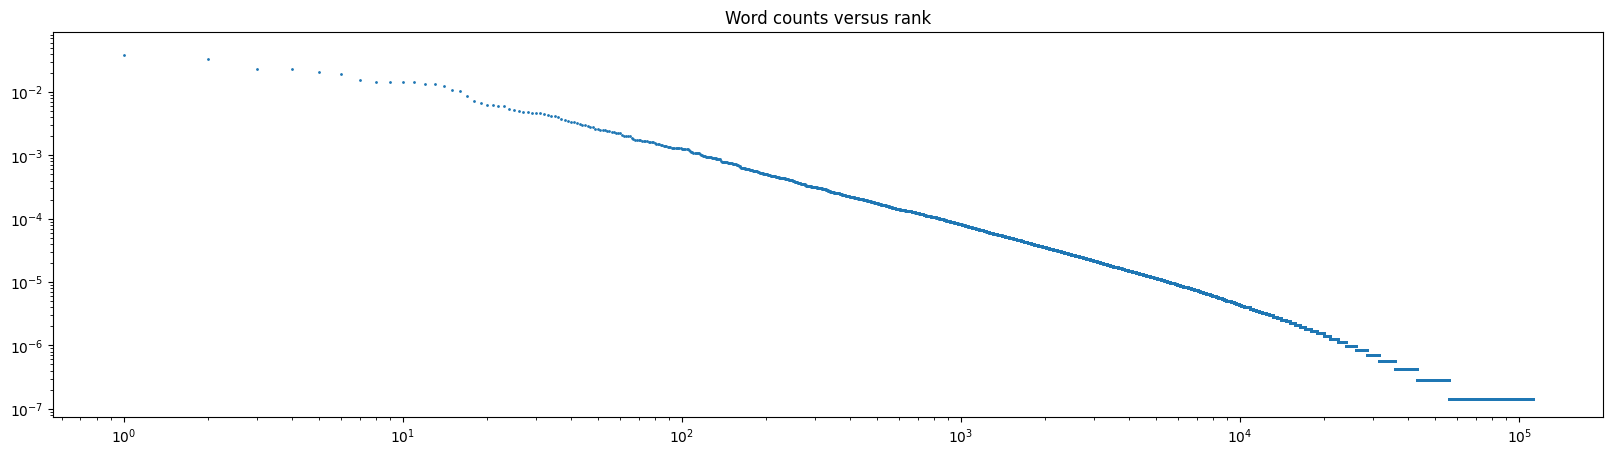

Vocabulary size: 111833
Part of the corpus by taking the "x" most frequent words ?


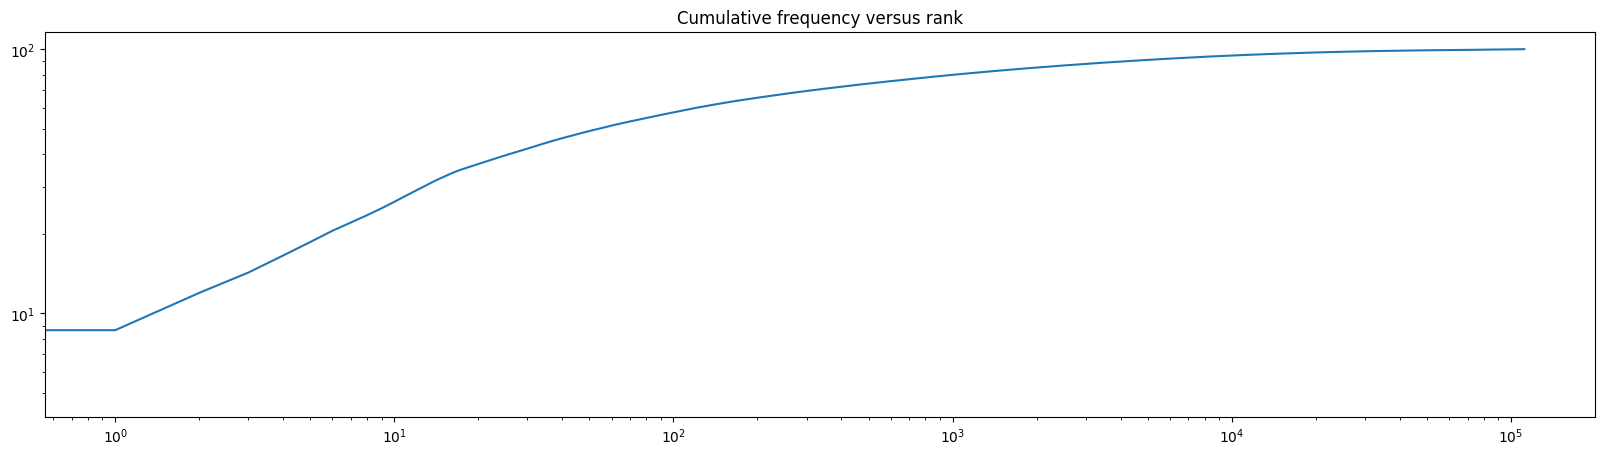

In [59]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts,0,0)

frequency = np.array(list(word_counts.values())) / np.sum(list(word_counts.values()))
rank = np.array(list(vocab.values()))

# We can for example use plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
#
#  To fill in !
#
plt.scatter(rank, frequency, s=1)
plt.yscale('log')
plt.xscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words ?')
#
#  To fill in !-
#
cum_frequency = np.cumsum(frequency) / np.sum(frequency) * 100

plt.figure(figsize=(20,5))
plt.title('Cumulative frequency versus rank')
plt.plot(rank, cum_frequency)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [60]:
print(len(vocab))

111833


<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Word2vec's implementation cuts the vocabulary size by using **only words with at least 5 occurences**, by default. What vocabulary size would it give here ? Does it seem like a good compromise, looking at the graph ?


Given a corpus of approximatly 20,000 texts, each with an approximate size of 1,000 words, we can estimate the total number of words in the corpus.

Total number of words = Number of texts x Average text size

Total number of words = 25,000 x 1,000

Total number of words = 25,000,000

Now, we can estimate the vocabulary size by considering Zipf's law. Zipf's law states that the frequency of a word is inversely proportional to its rank in the frequency table. It means that a few words are very common, while the majority of words in the vocabulary set are rare.

To estimate the vocabulary size, we need to consider the distribution of word frequencies in the corpus. Typically, a large portion of the vocabulary consists of rare words with low frequencies.

The plot shows the frequency distribution of words. Based on this graph, we can determine the frequency at which most words occur. If we set the minimum occurrence threshold at 5, it means that words occurring less than 5 times will be excluded from the vocabulary.

With a corpus of 25 million words and considering Zipf's law, we would expect a large number of unique words. Setting a minimum occurrence threshold of 5 would exclude many rare words, reducing the vocabulary size.

As we saw using the grid-search min_df = 5 is a part of the best hyperparameter set. As consequence this value should represent a good compromise. In fact, we were able to considerably reduce the number of words in our vocalbulary set (reducing it from 111833 to 31572 of the total number which represents around 28% of the intial vocabulary size) and despite having less features we got a very good performance (low bias and low variance) on the model.



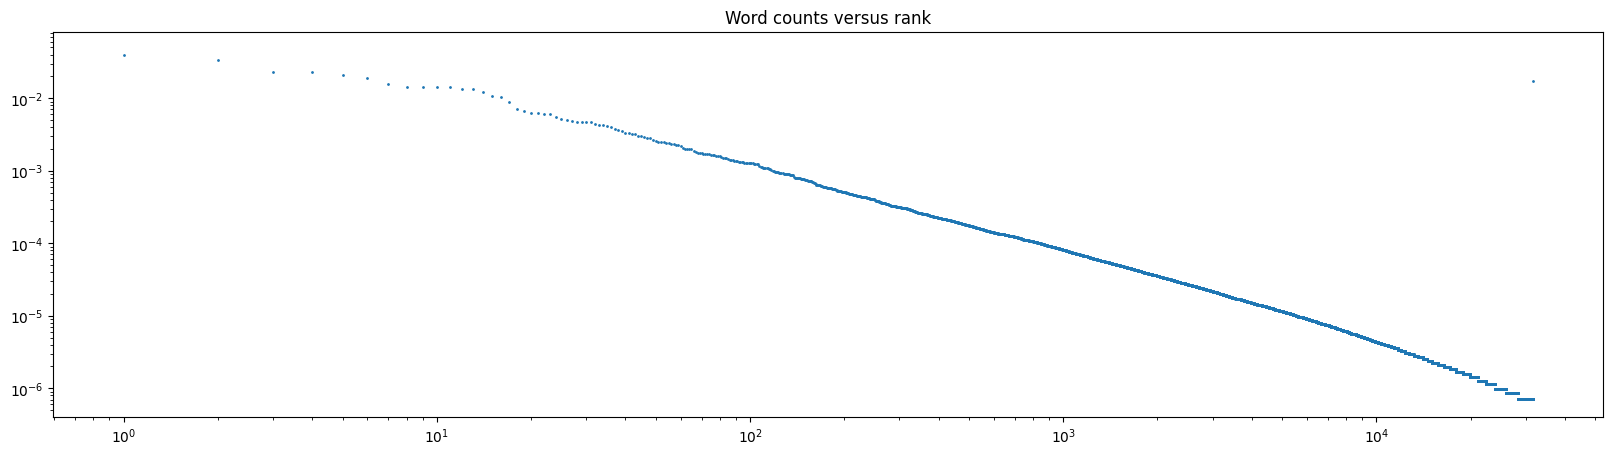

Vocabulary size: 31572
Part of the corpus by taking the "x" most frequent words ?


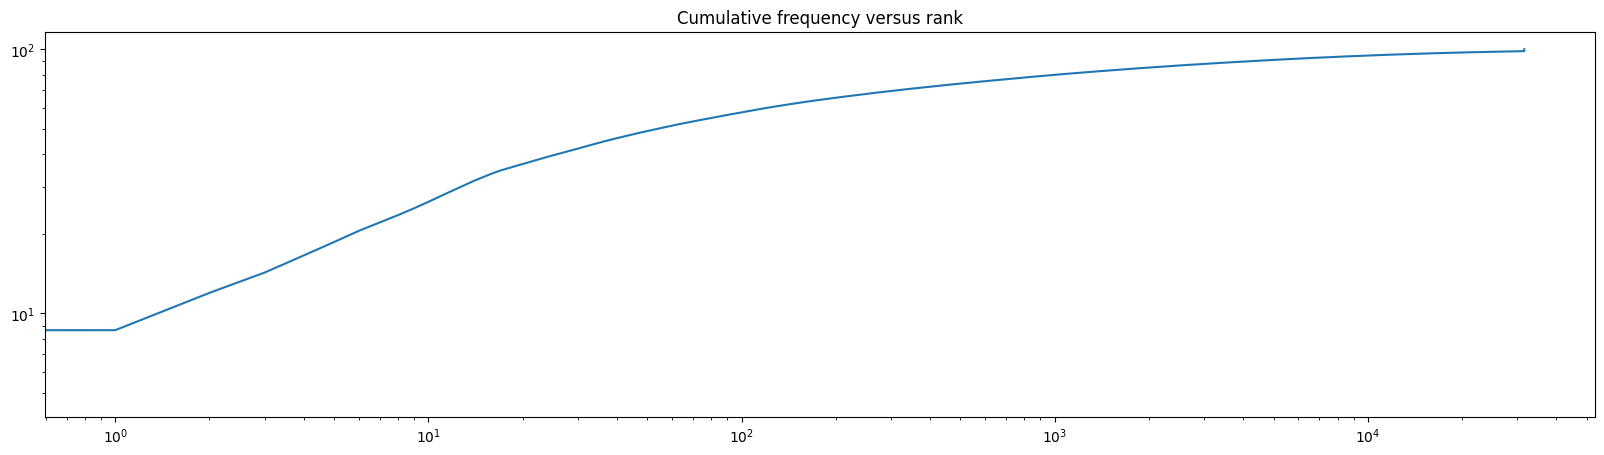

Part of the corpus by taking the 1000 most frequent words: 79.970 %
Part of the corpus by taking the 10000 most frequent words: 94.623 %
Part of the corpus by taking the 5000 most frequent words: 91.087 %


In [61]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts,5,0)

frequency = np.array(list(word_counts.values())) / np.sum(list(word_counts.values()))
rank = np.array(list(vocab.values()))

# We can for example use plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank, frequency, s=1)
plt.yscale('log')
plt.xscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words ?')
cum_frequency = np.cumsum(frequency) / np.sum(frequency) * 100

plt.figure(figsize=(20,5))
plt.title('Cumulative frequency versus rank')
plt.plot(rank, cum_frequency)
plt.yscale('log')
plt.xscale('log')
plt.show()

print('Part of the corpus by taking the 1000 most frequent words: %2.3f %%' % cum_frequency[999])
print('Part of the corpus by taking the 10000 most frequent words: %2.3f %%' % cum_frequency[9999])
print('Part of the corpus by taking the 5000 most frequent words: %2.3f %%' % cum_frequency[4999])

### With pre-processing tools from NLTK

We are now going to pre-process our textual data. **Note that this still will only be useful if we do not have a lot of training data to begin with !**

#### Stemming

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```from nltk import SnowballStemmer```

In [62]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

**Example:**

In [63]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [64]:
def stem(texts):
    texts_stem = []
    for text in texts:

        text_stem = [stemmer.stem(word) for word in word_tokenize(text.lower())]
        texts_stem.append(' '.join(text_stem))

    return texts_stem

#### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```pos_tag```

In [65]:
import nltk
from nltk import pos_tag, word_tokenize

**Example:**

In [66]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (```['NN', 'VB', 'ADJ', 'RB']```) for our model.

<div class='alert alert-block alert-info'>
            Code:</div>

In [67]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    X_pos = []
    for text in X:
        pos_tags = pos_tag(word_tokenize(text))
        text_pos = [word for word, tag in pos_tags if tag in good_tags]
        X_pos.append(' '.join(text_pos))

    return X_pos

### Application

<div class='alert alert-block alert-warning'>
            Questions:</div>

Re-draw the Zipf distribution of our data **after reducing their vocabulary with these functions**. How is it affected ? How do you think it could affect results here ?         
        
<div class='alert alert-block alert-info'>
            Code:</div>        

After reducing the vocabulary we noitice that Zipf distribution of data is not the same as before. This is because alot of communly used words was removed thus only the meaningful words remained. As consequence I think that this can improve the results since we are taking into account what matters more

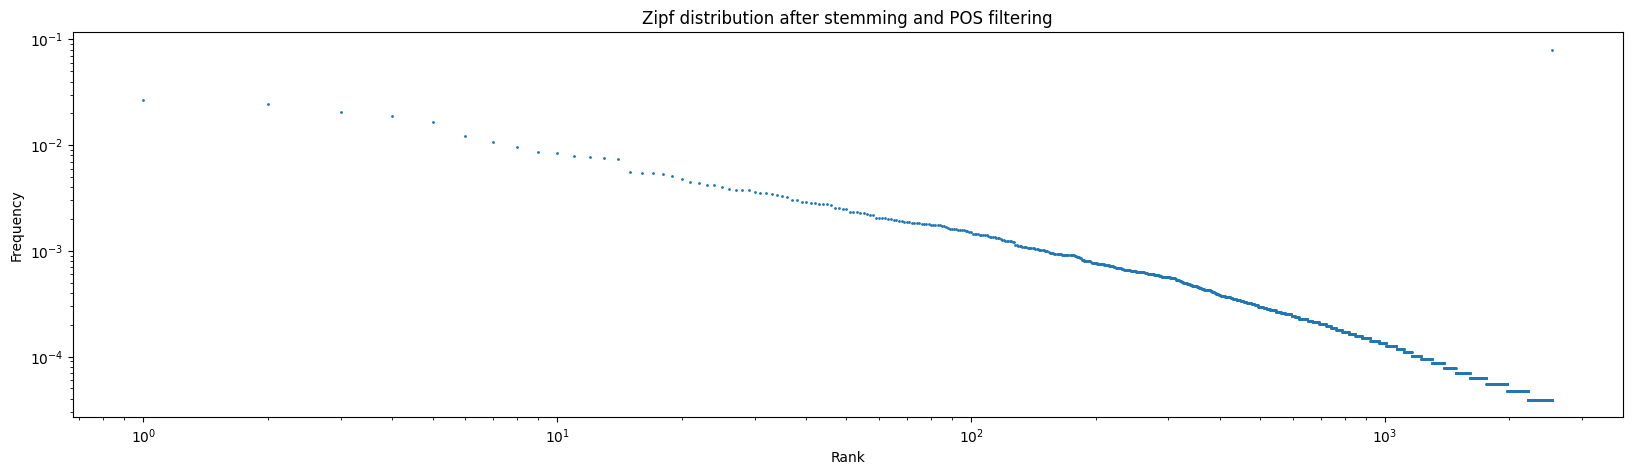

In [79]:
#Apply pos_tag_filter
train_texts_pos = pos_tag_filter(train_texts_splt)


#Preprocess texts using stemming
train_texts_stem = stem(train_texts_pos)

#Tokenize the preprocessed texts
vocab_stem, word_counts_stem = vocabulary(train_texts_stem,5,0)



#Plot the Zipf distribution
frequencies_stem = np.array(list(word_counts_stem.values())) / np.sum(list(word_counts_stem.values()))
rank_stem = np.array(list(vocab_stem.values()))

plt.figure(figsize=(20,5))
plt.title('Zipf distribution after stemming and POS filtering')
plt.scatter(rank_stem, frequencies_stem, s=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

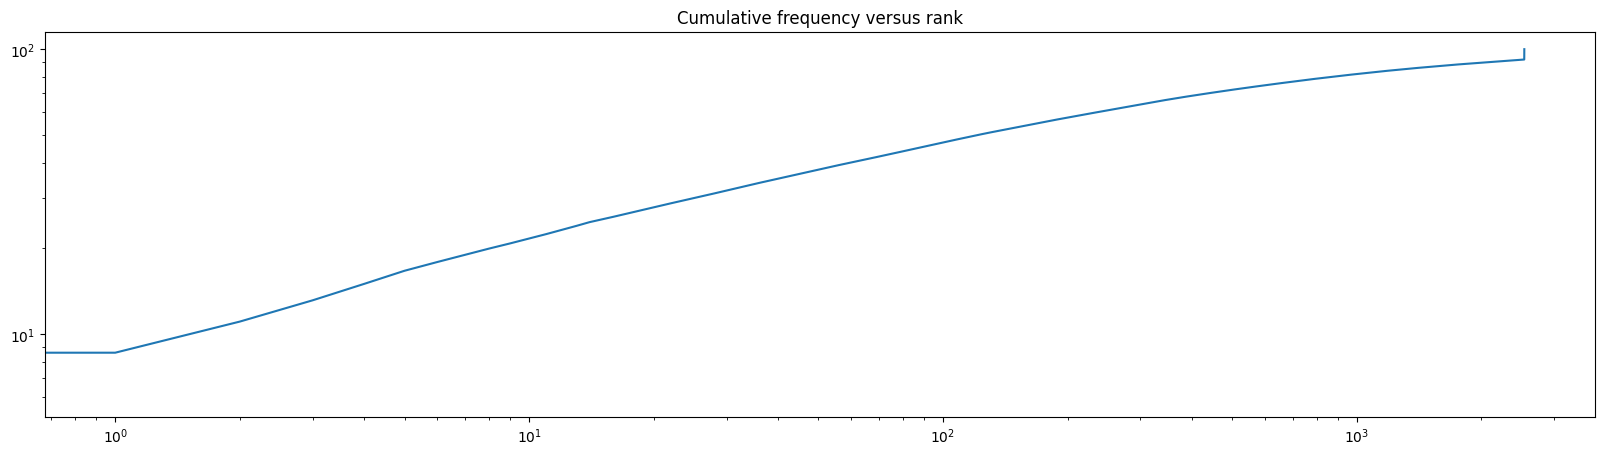

In [81]:
# We would like to know how much of the data is represented by the 'k' most frequent words
cum_frequency_stem = np.cumsum(frequencies_stem) / np.sum(frequencies_stem) * 100

plt.figure(figsize=(20,5))
plt.title('Cumulative frequency versus rank')
plt.plot(rank_stem, cum_frequency_stem)
plt.yscale('log')
plt.xscale('log')
plt.show()

By observing the cumulative frequence curve, we obtain a curve that is more linear than the pervious ones. This can be noitced in high ranks where if we incerease the ranks we get an incearse in cumulative frequency that is relativily constant because thanks to stemming and filtring there is less rare words that have the same root (languagly speaking) in the vocabulary. This words are aggregarate into one representitave thanks to stemming for example :

(stop stopped stopping stopp stoping )-> stop

Here we have five "different" strings that represent the same meaning. Thanks to stemming all of these forms will be converted into a single format that we can use.

In [87]:
pipeline_grid_stem = Pipeline([
    ('vect', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
param_grid_stem = {
    'vect__max_df': [0.5, 0.75,0.85, 1.0],
    'vect__min_df': [1, 2, 5],
    'vect__analyzer': ['word', 'char'],
    'vect__ngram_range': [(1, 1),(1,2)],
    'vect__max_features' : [30000],
    'vect__stop_words' :  [None]
}

In [88]:
grid_search_stem = GridSearchCV(pipeline_grid_stem, param_grid_stem, scoring="f1", n_jobs=-1, cv=5) # We use cross validation

In [89]:
grid_search_stem.fit(train_texts_stem, train_labels_splt)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfid', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__analyzer': ['word', 'char'],
                         'vect__max_df': [0.5, 0.75, 0.85, 1.0],
                         'vect__max_features': [30000],
                         'vect__min_df': [1, 2, 5],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': [None]},
             scoring='f1')

In [90]:
print("Best score: {:.4f}".format(grid_search_stem.best_score_))

Best score: 0.7676


In [91]:
grid_search_stem.best_params_

{'vect__analyzer': 'word',
 'vect__max_df': 0.75,
 'vect__max_features': 30000,
 'vect__min_df': 2,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [ ]:

best_model_variance = grid_search_stem.cv_results_['std_test_score'][grid_search_stem.best_index_]
best_model_variance

In [92]:
print(len(vocab_stem))

2539


In [82]:
#Apply pos_tag_filter
val_text_pos = pos_tag_filter(val_texts)
#Preprocess texts using stemming
val_text_stem = stem(val_text_pos)

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       250
           1       0.76      0.71      0.73       250

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



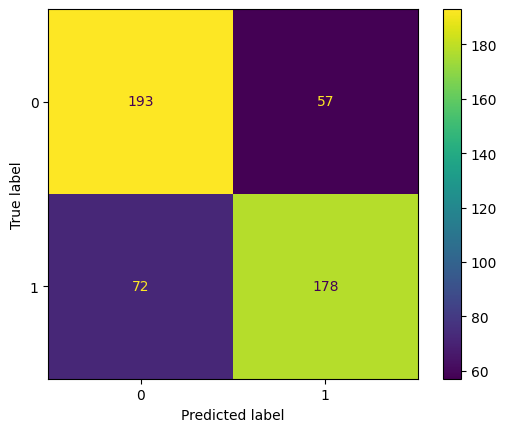

In [96]:
best_params = {key[6:]: param for key, param in zip(grid_search_stem.best_params_.keys(), grid_search_stem.best_params_.values())}
pipeline_base = Pipeline([
    ('vect', CountVectorizer(**best_params)),
    ('tfid', TfidfTransformer()),
    ('clf', MultinomialNB())
])
pipeline_base.fit(train_texts_stem, train_labels_splt)
val_pred_stem = pipeline_base.predict(val_text_stem)
get_results(val_labels, val_pred_stem)

**Conclusion**

This model enhanced with stemming and post_filtring as preprocessing is less performant in terms of f1-score. However, we gained in terms of data representation (our vocabulary is now limited to 2539 words which is a more compact and less memory consuming representation.

This is due to that fact that by using less features, we are less information that the first case. Furthermore, like we have seen in the cumulative frequency curve after stemming and POS filtering, we lost access to more wrods that could have been deterimental in classifing the documents. On the other hand, we have gained in terms of memory and computation since we are dealing with much lower porblem dimensionality